#### 패키지 로딩하기

In [1]:
from glob import glob
from matplotlib import pyplot as plt

import os
import cv2
import urllib
import tarfile
import numpy as np
import tensorflow as tf

## 이미지 1 : 사람이미지의 배경을 흐리게 만들기

#### 데이터 불러오기

(1341, 1011, 3)


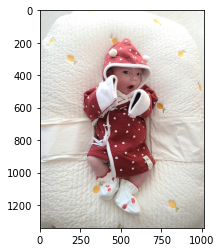

In [2]:
# image1은 사람사진임.
img1_path = os.getenv("HOME") + "/aiffel/human_segmentation/images/image1.jpg" # 불러올 파일의 경로와 이름을 지정
img1_orig = cv2.imread(img1_path)                                              # 이미지 불러오기

print(img1_orig.shape)                                                         # 이미지의 shape를 보고
plt.imshow(cv2.cvtColor(img1_orig, cv2.COLOR_BGR2RGB))                         # 이미지를 시각화도 해본다.
                                                                               # cv2가 이미지를 읽어오는 것을 생각하여 RGB순서를 알맞게 변환한다.
plt.show()

#### 구글에서 제공하는 모델 구조를 그대로 가지고 와서 DeepLabModel 클래스 만들기

* DeepLabModel 클래스 만들기
* https://github.com/tensorflow/models/blob/master/research/deeplab/deeplab_demo.ipynb 를 참고하여 노드대로 코드를 옮김.

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME  = "ImageTensor:0"
    OUTPUT_TENSOR_NAME = "SemanticPredictions:0"
    INPUT_SIZE         = 513
    FROZEN_GRAPH_NAME  = "frozen_inference_graph"
    
    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프 구조 graph_def를
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다.
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def  = None
        tar_file   = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def   = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()
        
        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name = "")
            
        self.sess = tf.compat.v1.Session(graph = self.graph)
        
    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio  = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size   = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb   = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input     = resized_rgb
        return img_input
    
    def run(self, image):
        img_input = self.preprocess(image)
        
        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict = {input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(self.OUTPUT_TENSOR_NAME, feed_dict = {self.INPUT_TENSOR_NAME : [img_input]})
        seg_map       = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

* 사전에 학습된 가중치(pretrained weight)를 불러오기
* 구글에서 제공하는 파일을 다운로드 한다.

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = "http://download.tensorflow.org/models/"                # 다운로드 받을 가중치가 있는 url 지정
model_dir            = os.getenv("HOME") + "/aiffel/human_segmentation/models" # 다운로드 된 모델이 있는 경로 지정
tf.io.gfile.makedirs(model_dir)                                                # (상위/중간/현재)의 디렉토리를 만들어준다.
print("temp directory :", model_dir)                                           # 경로 출력하기

temp directory : /home/aiffel-dj52/aiffel/human_segmentation/models


In [5]:
download_path = os.path.join(model_dir, "deeplab_model.tar.gz") # 다운로드 된 가중치의 경로 지정
if not os.path.exists(download_path):                           # 만약 다운로드된 가중치가 없다면 다운로드를 시킨다.
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + "deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz", download_path)
    
MODEL_1 = DeepLabModel(download_path)                           # 모델을 초기화하기
print("model loaded successfully!")                             # 위 코드가 성공적으로 수행됬다면 뜨는 문구

model loaded successfully!


#### 위에서 만든 모델에 이미지 파일을 넣어서 실행하기

In [6]:
img1_resized, seg_map_1 = MODEL_1.run(img1_orig)
print(img1_orig.shape, img1_resized.shape, seg_map_1.max())

(1341, 1011, 3) (513, 386, 3) 15


In [7]:
# 위에서 seg_map.max가 15가 나왔다. 즉, 구글에서 제공한 라벨 20개 중 15개가 이미지에 존재한다는 의미로 생각된다.

# 구글에서 제공한 DeepLab은 PASCAL VOC의 라벨로 학습이 되었다. 그 종류는 다음과 같다.
# 이 중 background를 제외한 20가지이다.
# 여기서 나온 15는 person을 의미하게 된다.
LABEL_NAMES = [
    "backgroud", "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse",
    "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tv"
]
len(LABEL_NAMES)

21

#### 사람의 영역만 추출하기

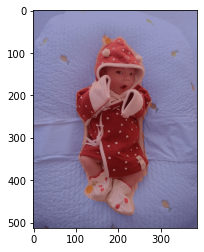

In [8]:
img1_show    = img1_resized.copy()                                      # resize된 이미지의 카피본 만들기
seg_map_1    = np.where(seg_map_1 == 15, 15, 0)                         # 예측 중 사람만 추출
img1_mask    = seg_map_1 * (255 / seg_map_1.max())                      # 255 normalization
img1_mask    = img1_mask.astype(np.uint8)                               # img1_mask의 type을 지정
color_mask_1 = cv2.applyColorMap(img1_mask, cv2.COLORMAP_JET)           # 주어진 이미지에 사용자 컬러맵을 적용시킨다.
img1_show    = cv2.addWeighted(img1_show, 0.6, color_mask_1, 0.35, 0.0) # 두 배열의 가중치 합계를 계산한다. gamma는 각각 더해줄 스칼라값
                                                                        # addWeighted(src1, alpha, src2, beta, gamma)

plt.imshow(cv2.cvtColor(img1_show, cv2.COLOR_BGR2RGB))                  # 결과물 시각화하기
plt.show()

#### 세그멘테이션 결과를 원래 크기로 복원하기
* DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력했다. 
* 따라서 출력도 resize 된 입력 크기와 같게 나오게 됩니다.
* 세그멘테이션 결과(mask)를 원래 크기로 복원해보기

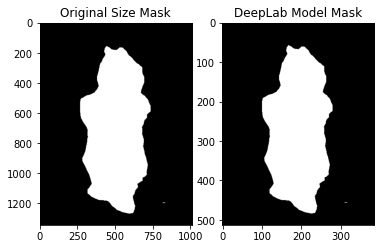

In [9]:
img1_mask_up               = cv2.resize(img1_mask, img1_orig.shape[:2][::-1], interpolation = cv2.INTER_LINEAR) # 이미지 resize하기
img1_show_up, img1_mask_up = cv2.threshold(img1_mask_up, 128, 255, cv2.THRESH_BINARY) # 각 배열 요소에 고정 임계값을 준다.

# 원본사이즈 이미지 시각화 (위의 2줄로 복원한 size)
ax = plt.subplot(1, 2, 1)
plt.imshow(img1_mask_up, cmap = plt.cm.binary_r)
ax.set_title("Original Size Mask")

# resize된 이미지 시각화 (모델을 돌리기 위해 크기를 줄인 size)
ax = plt.subplot(1, 2, 2)
plt.imshow(img1_mask, cmap = plt.cm.binary_r)
ax.set_title("DeepLab Model Mask")

plt.show() # 두 이미지가 언뜻 볼 때는 같아보이지만 좌표축들이 다르다.

#### 배경 흐리게 만들기

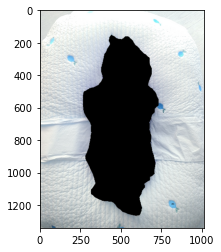

In [10]:
# 배경영역만 추출하기
img1_mask_color = cv2.cvtColor(img1_mask_up, cv2.COLOR_GRAY2BGR) # 지정한 영역의 색을 변경하기
img1_bg_mask    = cv2.bitwise_not(img1_mask_color)               # 배열의 모든 비트를 반전시킨다. 실행하면 0은 255로 255는 0으로 반전됨
img1_bg         = cv2.bitwise_and(img1_orig, img1_bg_mask)       # 두 비트의 결합을 계산한다. 실행하면 원래의 색으로 돌아오는 듯 함
plt.imshow(img1_bg)                                              # 결과물 시각화하기
plt.show()

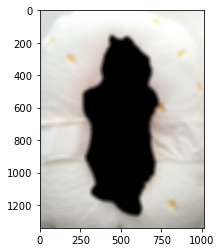

In [11]:
# 배경을 blur처리하기
img1_bg_blur = cv2.blur(img1_bg, (30, 30))
plt.imshow(cv2.cvtColor(img1_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### 배경과 원본 합성

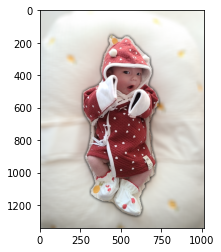

In [12]:
img1_concat = np.where(img1_mask_color == 255, img1_orig, img1_bg_blur)
plt.imshow(cv2.cvtColor(img1_concat, cv2.COLOR_BGR2RGB))
plt.show()

#### 이미지 1의 문제점

In [13]:
# 모자위의 당근과 왼쪽 발의 당근은 사람 영역이 아니지만 그 영역도 같이 포함이 되었다.

## 이미지 2 : 강아지 사진의 배경을 흐리게 만들기

#### 데이터 불러오기

(1041, 2003, 3)


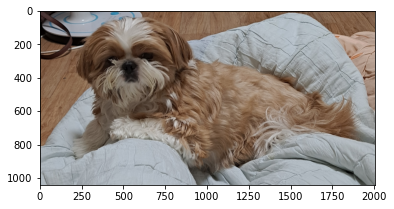

In [14]:
# image2은 강아지 사진임.
img2_path = os.getenv("HOME") + "/aiffel/human_segmentation/images/image2.jpg" # 불러올 파일의 경로와 이름을 지정
img2_orig = cv2.imread(img2_path)                                              # 이미지 불러오기

print(img2_orig.shape)                                                         # 이미지의 shape를 보고
plt.imshow(cv2.cvtColor(img2_orig, cv2.COLOR_BGR2RGB))                         # 이미지를 시각화도 해본다.
                                                                               # cv2가 이미지를 읽어오는 것을 생각하여 RGB순서를 알맞게 변환한다.
plt.show()

#### 모델 실행

In [15]:
MODEL_2 = DeepLabModel(download_path)                           # 모델을 초기화하기
print("model loaded successfully!")                             # 위 코드가 성공적으로 수행됬다면 뜨는 문구

model loaded successfully!


In [16]:
img2_resized, seg_map_2 = MODEL_2.run(img2_orig)
print(img2_orig.shape, img2_resized.shape, seg_map_2.max())

(1041, 2003, 3) (266, 513, 3) 12


#### 강아지 영역만 가져오기

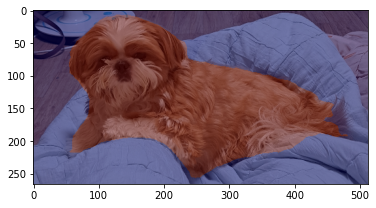

In [17]:
img2_show    = img2_resized.copy()                                      # resize된 이미지의 카피본 만들기
seg_map_2    = np.where(seg_map_2 == 12, 12, 0)                         # 예측 중 강아지만 추출
img2_mask    = seg_map_2 * (255 / seg_map_2.max())                      # 255 normalization
img2_mask    = img2_mask.astype(np.uint8)                               # img2_mask의 type을 지정
color_mask_2 = cv2.applyColorMap(img2_mask, cv2.COLORMAP_JET)           # 주어진 이미지에 사용자 컬러맵을 적용시킨다.
img2_show    = cv2.addWeighted(img2_show, 0.6, color_mask_2, 0.35, 0.0) # 두 배열의 가중치 합계를 계산한다. gamma는 각각 더해줄 스칼라값
                                                                        # addWeighted(src1, alpha, src2, beta, gamma)

plt.imshow(cv2.cvtColor(img2_show, cv2.COLOR_BGR2RGB))                  # 결과물 시각화하기
plt.show()

#### 세그멘테이션 결과를 원래 크기로 복원하기
* DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력했다. 
* 따라서 출력도 resize 된 입력 크기와 같게 나오게 됩니다.
* 세그멘테이션 결과(mask)를 원래 크기로 복원해보기

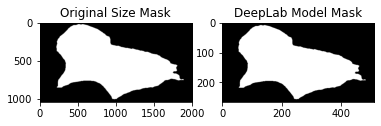

In [18]:
img2_mask_up               = cv2.resize(img2_mask, img2_orig.shape[:2][::-1], interpolation = cv2.INTER_LINEAR) # 이미지 resize하기
img2_show_up, img1_mask_up = cv2.threshold(img2_mask_up, 128, 255, cv2.THRESH_BINARY) # 각 배열 요소에 고정 임계값을 준다.

# 원본사이즈 이미지 시각화 (위의 2줄로 복원한 size)
ax = plt.subplot(1, 2, 1)
plt.imshow(img2_mask_up, cmap = plt.cm.binary_r)
ax.set_title("Original Size Mask")

# resize된 이미지 시각화 (모델을 돌리기 위해 크기를 줄인 size)
ax = plt.subplot(1, 2, 2)
plt.imshow(img2_mask, cmap = plt.cm.binary_r)
ax.set_title("DeepLab Model Mask")

plt.show() # 두 이미지가 언뜻 볼 때는 같아보이지만 좌표축들이 다르다.

#### 배경 흐리게 만들기

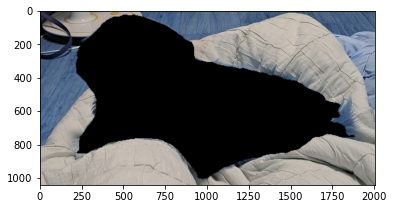

In [19]:
# 배경영역만 추출하기
img2_mask_color = cv2.cvtColor(img2_mask_up, cv2.COLOR_GRAY2BGR) # 지정한 영역의 색을 변경하기
img2_bg_mask    = cv2.bitwise_not(img2_mask_color)               # 배열의 모든 비트를 반전시킨다. 실행하면 0은 255로 255는 0으로 반전됨
img2_bg         = cv2.bitwise_and(img2_orig, img2_bg_mask)       # 두 비트의 결합을 계산한다. 실행하면 원래의 색으로 돌아오는 듯 함
plt.imshow(img2_bg)                                              # 결과물 시각화하기
plt.show()

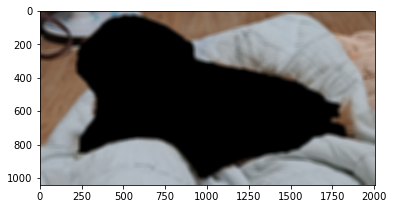

In [20]:
# 배경을 blur처리하기
img2_bg_blur = cv2.blur(img2_bg, (30, 30))
plt.imshow(cv2.cvtColor(img2_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### 배경과 원본 합성

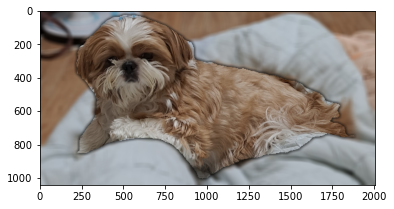

In [21]:
img2_concat = np.where(img2_mask_color == 255, img2_orig, img2_bg_blur)
plt.imshow(cv2.cvtColor(img2_concat, cv2.COLOR_BGR2RGB))
plt.show()

#### 이미지 2의 문제점

In [22]:
# 음....딱히 없는듯 하다. 귀여운 강아지가 잘 잘렸고...잘 붙었다.

## 이미지 3 : 배경 전환하기

#### 데이터 불러오기

(3024, 4032, 3)


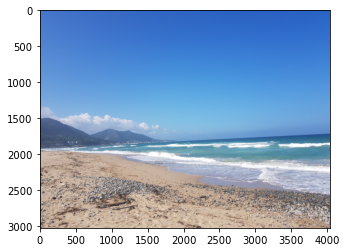

In [23]:
# image3은 배경 사진임.
img3_path = os.getenv("HOME") + "/aiffel/human_segmentation/images/image3.jpg" # 불러올 파일의 경로와 이름을 지정
img3_orig = cv2.imread(img3_path)                                              # 이미지 불러오기

print(img3_orig.shape)                                                         # 이미지의 shape를 보고
plt.imshow(cv2.cvtColor(img3_orig, cv2.COLOR_BGR2RGB))                         # 이미지를 시각화도 해본다.
                                                                               # cv2가 이미지를 읽어오는 것을 생각하여 RGB순서를 알맞게 변환한다.
plt.show()

#### 배경 전환을 위해 각 shape를 출력하기

In [24]:
print(img1_orig.shape)
print(img2_orig.shape)
print(img3_orig.shape)

(1341, 1011, 3)
(1041, 2003, 3)
(3024, 4032, 3)


#### 이미지 1의 사진에 이미지 3 배경을 넣기

In [25]:
img3_1 = np.resize(img3_orig, (1341, 1011, 3))
img3_1.shape

(1341, 1011, 3)

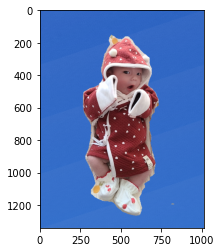

In [26]:
img3_1_concat = np.where(img1_mask_color == 255, img1_orig, img3_1)
plt.imshow(cv2.cvtColor(img3_1_concat, cv2.COLOR_BGR2RGB))
plt.show()

#### 이미지 2의 사진에 이미지 3 배경을 넣기

In [27]:
img3_2 = np.resize(img3_orig, (1041, 2003, 3))
img3_2.shape

(1041, 2003, 3)

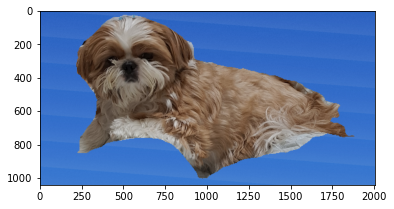

In [28]:
img3_2_concat = np.where(img2_mask_color == 255, img2_orig, img3_2)
plt.imshow(cv2.cvtColor(img3_2_concat, cv2.COLOR_BGR2RGB))
plt.show()

#### 이미지 3의 문제점

In [29]:
# 배경으로 쓸 사진이 너무 커서 하늘만 배경으로 잘린 듯하다.
# 사진을 붙이니까 스티커를 붙인거 처럼 어색하다.